In [1]:
### import
import torch
from torch import nn
import torch.optim as optim
import torchvision

import numpy as np
import matplotlib.pyplot as plt

import copy
import pickle

from datasets import TrainDataset, EvalDataset


In [2]:
### device setting
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
### hyperparameters setting
num_epochs = 4
num_classes = 10
batch_size = 16

kernel_size = [9,1,5]

In [4]:
### Dataset setting
train_dataset_file = 'dataset/91-image_x3.h5'
eval_dataset_file = 'dataset/Set5_x3.h5'

class transform_class:
    def __init__(self):
        self.transform_crop = None
    
    def crop(self, fsub1, fsub2):
        self.crop_transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(), # HxWxC to CxHxW
            torchvision.transforms.CenterCrop((fsub1-sum(kernel_size)+3,fsub2-sum(kernel_size)+3)) # fsub-f1-f2-f3+3 | 33-9-1-5+3
        ])
        return self.crop_transform

tranform_train = transform_class()
transform_eval = transform_class()

train_dataset = TrainDataset(root=train_dataset_file, target_transform=tranform_train.crop(33,33))
eval_dataset = EvalDataset(root=eval_dataset_file, target_transform=transform_eval)

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset,
                                          batch_size=1,
                                          shuffle=False)

In [6]:
### Checking data
print('number of train data: (about)', batch_size*len(train_loader))
print('number of eval data: ', 1*len(eval_loader))

for X_train, y_train in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type()) # input
    print('y_train:', y_train.size(), 'type:', y_train.type()) # ground truth high-resolution image
    break

for X_eval, y_eval in eval_loader:
    print('X_eval:', X_eval.size(), 'type:', X_eval.type()) # input
    print('y_eval:', y_eval.size(), 'type:', y_eval.type()) # ground truth high-resolution image

number of train data: (about) 21888
number of eval data:  5
X_train: torch.Size([16, 1, 33, 33]) type: torch.FloatTensor
y_train: torch.Size([16, 1, 21, 21]) type: torch.FloatTensor
X_eval: torch.Size([1, 1, 510, 510]) type: torch.FloatTensor
y_eval: torch.Size([1, 1, 498, 498]) type: torch.FloatTensor
X_eval: torch.Size([1, 1, 288, 288]) type: torch.FloatTensor
y_eval: torch.Size([1, 1, 276, 276]) type: torch.FloatTensor
X_eval: torch.Size([1, 1, 255, 255]) type: torch.FloatTensor
y_eval: torch.Size([1, 1, 243, 243]) type: torch.FloatTensor
X_eval: torch.Size([1, 1, 279, 279]) type: torch.FloatTensor
y_eval: torch.Size([1, 1, 267, 267]) type: torch.FloatTensor
X_eval: torch.Size([1, 1, 342, 228]) type: torch.FloatTensor
y_eval: torch.Size([1, 1, 330, 216]) type: torch.FloatTensor


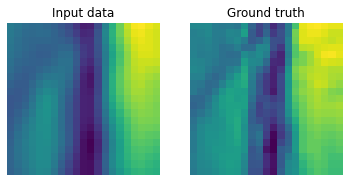

In [7]:
### Show image
fig = plt.figure()
rows = 1
cols = 2

crop_transform = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(21)
])

ax1 = fig.add_subplot(rows, cols, 1)
img1 = crop_transform(X_train[0][0])
ax1.imshow(img1)
ax1.set_title('Input data')
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(y_train[0][0])
ax2.set_title('Ground truth')
ax2.axis("off")

plt.show()

In [8]:
### SRCNN model
class SRCNN(nn.Module):
    def __init__(self, num_channels=1): # in_channels : RGB or YCbCr
        super(SRCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=kernel_size[0], stride=1, padding=0),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=kernel_size[1], stride=1, padding=0),
            nn.ReLU())

        self.layer3 = nn.Conv2d(in_channels=32, out_channels=num_channels, kernel_size=kernel_size[2], stride=1, padding=0)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [9]:
### Configure Optimizer, Objective function
model = SRCNN().to(device)
optimizer = torch.optim.SGD([
                                {'params': model.layer1.parameters()},
                                {'params': model.layer2.parameters()},
                                {'params': model.layer3.parameters(), 'lr': 1e-5}
                            ], lr=1e-4, momentum=0.9)
criterion = nn.MSELoss()

def PSNR(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 10.0 * torch.log10(1.0 / mse)

print(model)
print('\n')
print('Number of parameters: {}'.format(sum(p.numel() for p in model.parameters())))
for p in model.parameters():
    print(p.size())

SRCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1))
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
  )
  (layer3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1))
)


Number of parameters: 8129
torch.Size([64, 1, 9, 9])
torch.Size([64])
torch.Size([32, 64, 1, 1])
torch.Size([32])
torch.Size([1, 32, 5, 5])
torch.Size([1])


In [10]:
### model training 
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)

        # Forward pass
        output = model(image)
        loss = criterion(output, label)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Printing the result at the specific interval
        if batch_idx % log_interval == 0: # log_interval = 100
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx, len(train_loader), 100. * batch_idx / len(train_loader),
                loss.item()))

In [11]:
### model evaluating
def evaluate(model, eval_loader):
    model.eval()
    
    eval_loss = 0
    correct = 0

    psnr_list = []

    with torch.no_grad():
        for image, label in eval_loader:
            image = image.to(device)
            label = label.to(device)
            
            output = model(image)

            # psnr caculate
            psnr_list.append(PSNR(output,label))
            eval_loss += criterion(output, label).item()

    eval_loss /= len(eval_loader.dataset)
    eval_psnr = sum(psnr_list)/len(psnr_list)
    return eval_loss, eval_psnr

In [12]:
### Training and Evaluating
psnr_epoch = []
for epoch in range(1, num_epochs + 1):
    train(model, train_loader, optimizer, log_interval = 100)
    eval_loss, eval_psnr = evaluate(model, eval_loader)
    print("\n[EPOCH: {}/{}], \tEvaluate Loss: {:.4f}, \tEvaluate PSNR: {:.2f} % \n".format(
        epoch, num_epochs, eval_loss, eval_psnr))
    psnr_epoch.append(eval_psnr)

pickle.dump(psnr_epoch, open('./results/psnr_list.pickle','wb'))

model_weight = copy.deepcopy(model.state_dict())
torch.save(model_weight, './results/model_weight.pth')


Train Epoch: 1 [0/1368 (0%)]	Train Loss: 0.232904
Train Epoch: 1 [100/1368 (7%)]	Train Loss: 0.078847
Train Epoch: 1 [200/1368 (15%)]	Train Loss: 0.021153
Train Epoch: 1 [300/1368 (22%)]	Train Loss: 0.006669
Train Epoch: 1 [400/1368 (29%)]	Train Loss: 0.011134
Train Epoch: 1 [500/1368 (37%)]	Train Loss: 0.005458
Train Epoch: 1 [600/1368 (44%)]	Train Loss: 0.008103
Train Epoch: 1 [700/1368 (51%)]	Train Loss: 0.006350
Train Epoch: 1 [800/1368 (58%)]	Train Loss: 0.005433
Train Epoch: 1 [900/1368 (66%)]	Train Loss: 0.005365
Train Epoch: 1 [1000/1368 (73%)]	Train Loss: 0.007483
Train Epoch: 1 [1100/1368 (80%)]	Train Loss: 0.007519
Train Epoch: 1 [1200/1368 (88%)]	Train Loss: 0.005940
Train Epoch: 1 [1300/1368 (95%)]	Train Loss: 0.004909

[EPOCH: 1/2], 	Evaluate Loss: 0.0059, 	Evaluate PSNR: 23.09 % 

Train Epoch: 2 [0/1368 (0%)]	Train Loss: 0.006956
Train Epoch: 2 [100/1368 (7%)]	Train Loss: 0.003938
Train Epoch: 2 [200/1368 (15%)]	Train Loss: 0.008637
Train Epoch: 2 [300/1368 (22%)]	Train 

In [34]:
### Graph extract
def show_result():
    psnr_epoch = pickle.load(open('./results/psnr_list.pickle','rb'))
    print(psnr_epoch)
    a = [1,2]

    plt.plot(list(range(1, len(psnr_epoch)+1)), psnr_epoch)
    plt.xlabel('epochs')
    plt.ylabel('Average PSNR')
    plt.savefig('./results/PSNR_Graph.png')
    plt.show()

[tensor(23.0927), tensor(24.6120)]


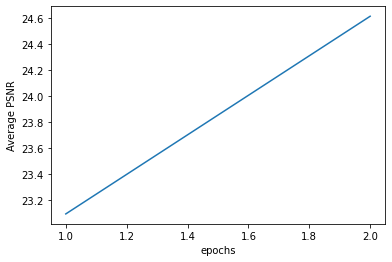

In [35]:
show_result()

[1, 2]